   Author: Ankit Kariryaa, University of Bremen

### Getting started
Define the paths to the dataset and trained models in the `notebooks/config/UNetTraining.py` file.  

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image
import rasterio
import imgaug as ia
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import imageio
import os
import time
import rasterio.warp             # Reproject raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info import FrameInfo
from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset
from core.visualize import display_images

import json
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(tf.__version__)

2.9.1


In [3]:
# Required configurations (including the input and output paths) are stored in a separate file (such as config/UNetTraining.py)
# Please provide required info in the file before continuing with this notebook. 
 
from config import UNetTraining
# In case you are using a different folder name such as configLargeCluster, then you should import from the respective folder 
# Eg. from configLargeCluster import UNetTraining
config = UNetTraining.Configuration()

In [4]:
# Read all images/frames into memory
frames = []

all_files = os.listdir(config.base_dir)
all_files_ndvi = [fn for fn in all_files if fn.startswith(config.ndvi_fn) and fn.endswith(config.image_type)]
len(all_files_ndvi)
for i, fn in enumerate(all_files_ndvi):
    ndvi_img = rasterio.open(os.path.join(config.base_dir, fn))
    pan_img = rasterio.open(os.path.join(config.base_dir, fn.replace(config.ndvi_fn,config.pan_fn)))
    read_ndvi_img = ndvi_img.read()
    read_pan_img = pan_img.read()
    comb_img = np.concatenate((read_ndvi_img, read_pan_img), axis=0)
    comb_img = np.transpose(comb_img, axes=(1,2,0)) #Channel at the end
    annotation_im = Image.open(os.path.join(config.base_dir, fn.replace(config.ndvi_fn,config.annotation_fn)))
    annotation = np.array(annotation_im)
    weight_im = Image.open(os.path.join(config.base_dir, fn.replace(config.ndvi_fn,config.weight_fn)))
    weight = np.array(weight_im)
    f = FrameInfo(comb_img, annotation, weight)
    frames.append(f)

3

In [5]:
training_frames, validation_frames, testing_frames  = split_dataset(frames, config.frames_json, config.patch_dir)
# training_frames = validation_frames = testing_frames  = list(range(len(frames)))

annotation_channels = config.input_label_channel + config.input_weight_channel
train_generator = DataGenerator(config.input_image_channel, config.patch_size, training_frames, frames, annotation_channels, augmenter = 'iaa').random_generator(config.BATCH_SIZE, normalize = config.normalize)
val_generator = DataGenerator(config.input_image_channel, config.patch_size, validation_frames, frames, annotation_channels, augmenter= None).random_generator(config.BATCH_SIZE, normalize = config.normalize)
test_generator = DataGenerator(config.input_image_channel, config.patch_size, testing_frames, frames, annotation_channels, augmenter= None).random_generator(config.BATCH_SIZE, normalize = config.normalize)

Reading train-test split from file
training_frames [0]
validation_frames [2]
testing_frames [1]


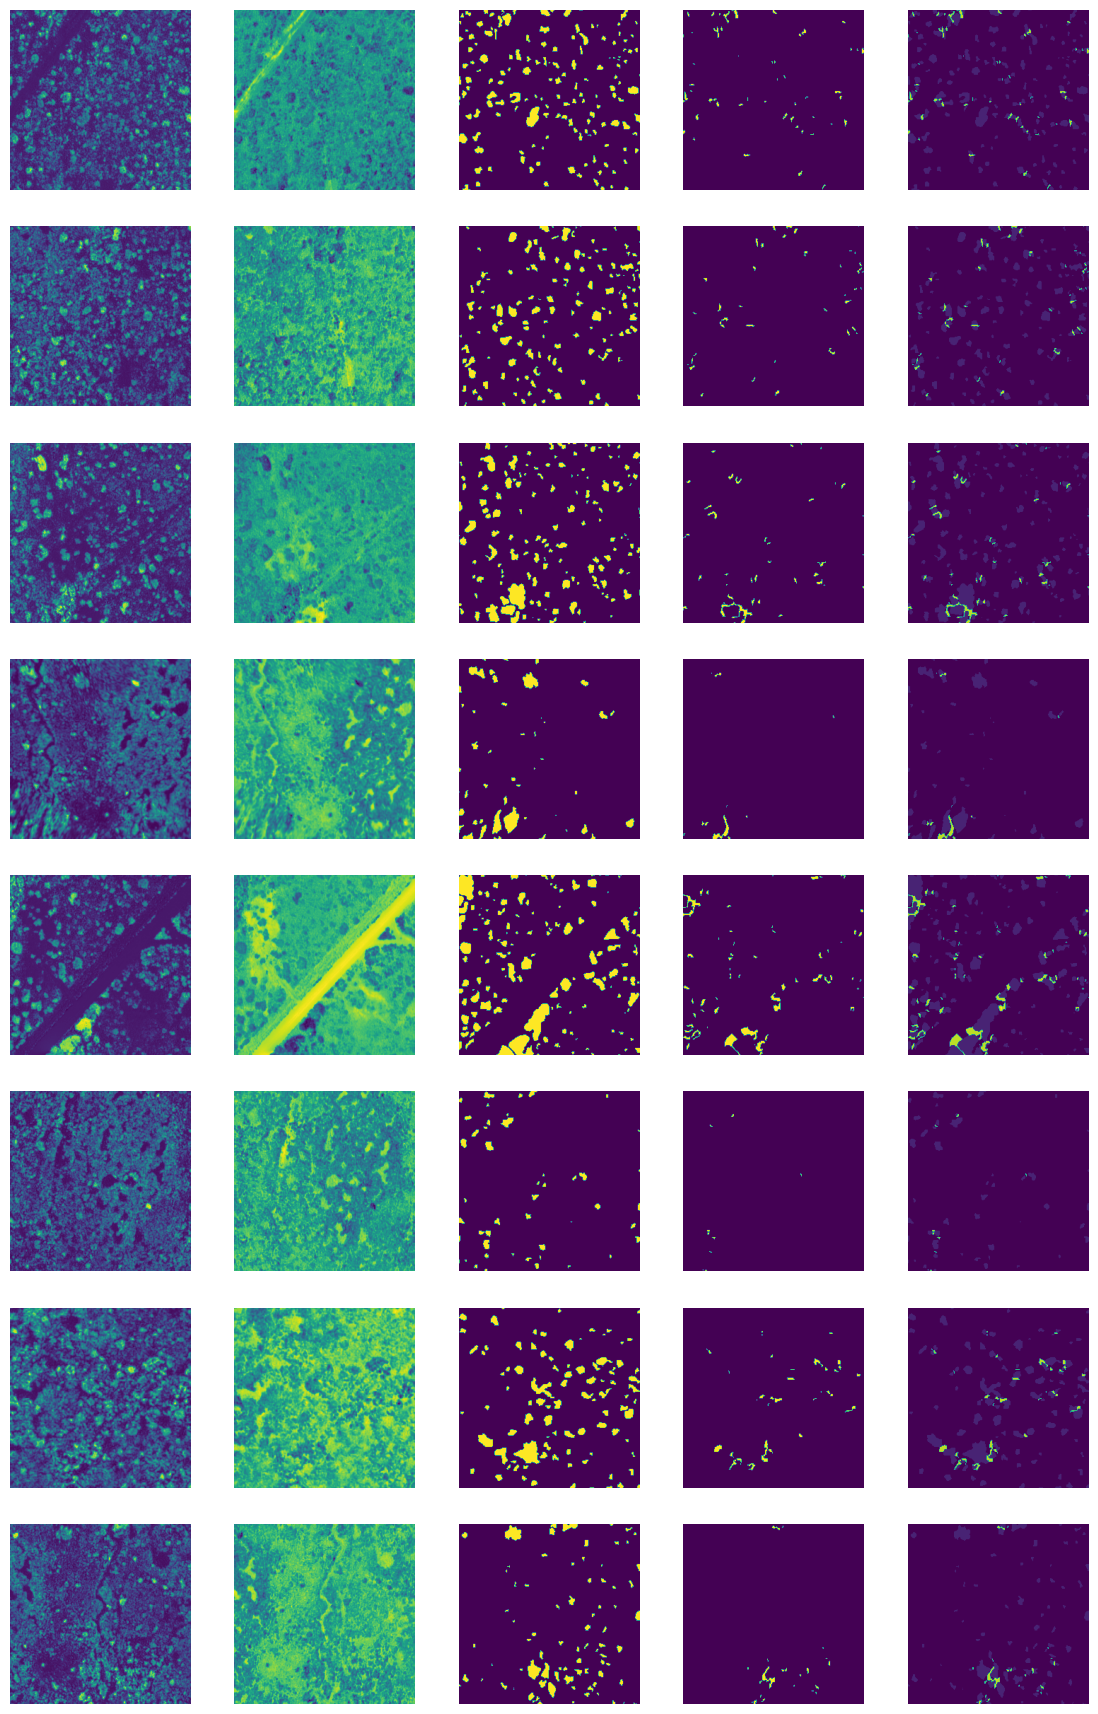

In [6]:
for _ in range(1):
    train_images, real_label = next(train_generator)
    ann = real_label[:,:,:,0]
    wei = real_label[:,:,:,1]
    #overlay of annotation with boundary to check the accuracy
    #5 images in each row are: pan, ndvi, annotation, weight(boundary), overlay of annotation with weight
    overlay = ann + wei
    overlay = overlay[:,:,:,np.newaxis]
    display_images(np.concatenate((train_images,real_label, overlay), axis = -1))

In [7]:
OPTIMIZER = adaDelta
LOSS = tversky 

#Only for the name of the model in the very end
OPTIMIZER_NAME = 'AdaDelta'
LOSS_NAME = 'weightmap_tversky'

# Declare the path to the final model
# If you want to retrain an exising model then change the cell where model is declared. 
# This path is for storing a model after training.

timestr = time.strftime("%Y%m%d-%H%M")
chf = config.input_image_channel + config.input_label_channel
chs = reduce(lambda a,b: a+str(b), chf, '')


if not os.path.exists(config.model_path):
    os.makedirs(config.model_path)
model_path = os.path.join(config.model_path,'trees_{}_{}_{}_{}_{}.h5'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs,config.input_shape[0]))

# The weights without the model architecture can also be saved. Just saving the weights is more efficent.

# weight_path="./saved_weights/UNet/{}/".format(timestr)
# if not os.path.exists(weight_path):
#     os.makedirs(weight_path)
# weight_path=weight_path + "{}_weights.best.hdf5".format('UNet_model')
# print(weight_path)

In [8]:
# Define the model and compile it
model = UNet([config.BATCH_SIZE, *config.input_shape],config.input_label_channel)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, specificity, sensitivity, accuracy])

2022-08-31 04:47:48.575471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:47:50.795647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:47:50.795916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:47:50.799718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1216        ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 128, 38  0           ['batch_normalization_6[0][0]',  
                                4)                                'batch_normalization_1[0][0]']  
                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 12  442496      ['concatenate_2[0][0]']          
                                8)                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 12  147584      ['conv2d_14[0][0]']              
                                8)                                                                
                                                                                                  
 up_sampli

In [9]:
# Define callbacks for the early stopping of training, LearningRateScheduler and model checkpointing
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard


checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

#reduceonplatea; It can be useful when using adam as optimizer
#Reduce learning rate when a metric has stopped improving (after some patience,reduce by a factor of 0.33, new_lr = lr * factor).
#cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=4, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=4, min_lr=1e-16)

#early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=15)

log_dir = os.path.join('./logs','UNet_{}_{}_{}_{}_{}'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs, config.input_shape[0]))
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_list = [checkpoint, tensorboard] #reduceLROnPlat is not required with adaDelta

In [10]:
loss_history = [model.fit(train_generator, 
                         steps_per_epoch=config.MAX_TRAIN_STEPS, 
                         epochs=config.NB_EPOCHS, 
                         validation_data=val_generator,
                         validation_steps=config.VALID_IMG_COUNT,
                         callbacks=callbacks_list,
                         workers=1,
#                         use_multiprocessing=True # the generator is not very thread safe
                        )]

Epoch 1/200


2022-08-31 04:49:20.501240: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


1000/1000 [==============================] - ETA: 0s - loss: 0.2457 - dice_coef: 0.9054 - dice_loss: 0.0946 - specificity: 0.9851 - sensitivity: 0.7133 - accuracy: 0.9633
Epoch 1: val_loss improved from inf to 0.42792, saving model to /home/ubuntu/data/trained_model/trees_20220831-0447_AdaDelta_weightmap_tversky_012_256.h5
1000/1000 [==============================] - 407s 317ms/step - loss: 0.2457 - dice_coef: 0.9054 - dice_loss: 0.0946 - specificity: 0.9851 - sensitivity: 0.7133 - accuracy: 0.9633 - val_loss: 0.4279 - val_dice_coef: 0.9365 - val_dice_loss: 0.0635 - val_specificity: 0.9550 - val_sensitivity: 0.9517 - val_accuracy: 0.9549
Epoch 2/200
1000/1000 [==============================] - ETA: 0s - loss: 0.1789 - dice_coef: 0.9641 - dice_loss: 0.0359 - specificity: 0.9899 - sensitivity: 0.7792 - accuracy: 0.9729
Epoch 2: val_loss improved from 0.42792 to 0.38610, saving model to /home/ubuntu/data/trained_model/trees_20220831-0447_AdaDelta_weightmap_tversky_012_256.h5
1000/1000 [==

1000/1000 [==============================] - ETA: 0s - loss: 0.0736 - dice_coef: 0.9847 - dice_loss: 0.0153 - specificity: 0.9959 - sensitivity: 0.9022 - accuracy: 0.9883
Epoch 15: val_loss did not improve from 0.37721
1000/1000 [==============================] - 306s 306ms/step - loss: 0.0736 - dice_coef: 0.9847 - dice_loss: 0.0153 - specificity: 0.9959 - sensitivity: 0.9022 - accuracy: 0.9883 - val_loss: 0.4089 - val_dice_coef: 0.9519 - val_dice_loss: 0.0481 - val_specificity: 0.9622 - val_sensitivity: 0.9100 - val_accuracy: 0.9599
Epoch 16/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0713 - dice_coef: 0.9852 - dice_loss: 0.0148 - specificity: 0.9960 - sensitivity: 0.9048 - accuracy: 0.9887
Epoch 16: val_loss did not improve from 0.37721
1000/1000 [==============================] - 313s 314ms/step - loss: 0.0713 - dice_coef: 0.9852 - dice_loss: 0.0148 - specificity: 0.9960 - sensitivity: 0.9048 - accuracy: 0.9887 - val_loss: 0.4047 - val_dice_coef: 0.9519 - val_

Epoch 30/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0558 - dice_coef: 0.9882 - dice_loss: 0.0118 - specificity: 0.9969 - sensitivity: 0.9249 - accuracy: 0.9911
Epoch 30: val_loss did not improve from 0.37721
1000/1000 [==============================] - 308s 308ms/step - loss: 0.0558 - dice_coef: 0.9882 - dice_loss: 0.0118 - specificity: 0.9969 - sensitivity: 0.9249 - accuracy: 0.9911 - val_loss: 0.4014 - val_dice_coef: 0.9535 - val_dice_loss: 0.0465 - val_specificity: 0.9636 - val_sensitivity: 0.9122 - val_accuracy: 0.9613
Epoch 31/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0562 - dice_coef: 0.9882 - dice_loss: 0.0118 - specificity: 0.9969 - sensitivity: 0.9245 - accuracy: 0.9911
Epoch 31: val_loss did not improve from 0.37721
1000/1000 [==============================] - 316s 317ms/step - loss: 0.0562 - dice_coef: 0.9882 - dice_loss: 0.0118 - specificity: 0.9969 - sensitivity: 0.9245 - accuracy: 0.9911 - val_loss: 0.3896 - val_dice_coef: 

Epoch 45/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0483 - dice_coef: 0.9897 - dice_loss: 0.0103 - specificity: 0.9973 - sensitivity: 0.9347 - accuracy: 0.9923
Epoch 45: val_loss did not improve from 0.37721
1000/1000 [==============================] - 313s 313ms/step - loss: 0.0483 - dice_coef: 0.9897 - dice_loss: 0.0103 - specificity: 0.9973 - sensitivity: 0.9347 - accuracy: 0.9923 - val_loss: 0.4006 - val_dice_coef: 0.9538 - val_dice_loss: 0.0462 - val_specificity: 0.9634 - val_sensitivity: 0.9124 - val_accuracy: 0.9611
Epoch 46/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0489 - dice_coef: 0.9896 - dice_loss: 0.0104 - specificity: 0.9974 - sensitivity: 0.9332 - accuracy: 0.9922
Epoch 46: val_loss did not improve from 0.37721
1000/1000 [==============================] - 315s 316ms/step - loss: 0.0489 - dice_coef: 0.9896 - dice_loss: 0.0104 - specificity: 0.9974 - sensitivity: 0.9332 - accuracy: 0.9922 - val_loss: 0.3965 - val_dice_coef: 

Epoch 60/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0436 - dice_coef: 0.9907 - dice_loss: 0.0093 - specificity: 0.9975 - sensitivity: 0.9421 - accuracy: 0.9931
Epoch 60: val_loss did not improve from 0.37721
1000/1000 [==============================] - 309s 309ms/step - loss: 0.0436 - dice_coef: 0.9907 - dice_loss: 0.0093 - specificity: 0.9975 - sensitivity: 0.9421 - accuracy: 0.9931 - val_loss: 0.4015 - val_dice_coef: 0.9542 - val_dice_loss: 0.0458 - val_specificity: 0.9636 - val_sensitivity: 0.9076 - val_accuracy: 0.9611
Epoch 61/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0439 - dice_coef: 0.9906 - dice_loss: 0.0094 - specificity: 0.9975 - sensitivity: 0.9414 - accuracy: 0.9930
Epoch 61: val_loss did not improve from 0.37721
1000/1000 [==============================] - 313s 313ms/step - loss: 0.0439 - dice_coef: 0.9906 - dice_loss: 0.0094 - specificity: 0.9975 - sensitivity: 0.9414 - accuracy: 0.9930 - val_loss: 0.4362 - val_dice_coef: 

Epoch 75/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0408 - dice_coef: 0.9912 - dice_loss: 0.0088 - specificity: 0.9977 - sensitivity: 0.9450 - accuracy: 0.9935
Epoch 75: val_loss did not improve from 0.37721
1000/1000 [==============================] - 317s 318ms/step - loss: 0.0408 - dice_coef: 0.9912 - dice_loss: 0.0088 - specificity: 0.9977 - sensitivity: 0.9450 - accuracy: 0.9935 - val_loss: 0.4002 - val_dice_coef: 0.9532 - val_dice_loss: 0.0468 - val_specificity: 0.9628 - val_sensitivity: 0.9096 - val_accuracy: 0.9603
Epoch 76/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0412 - dice_coef: 0.9912 - dice_loss: 0.0088 - specificity: 0.9977 - sensitivity: 0.9448 - accuracy: 0.9935
Epoch 76: val_loss did not improve from 0.37721
1000/1000 [==============================] - 314s 314ms/step - loss: 0.0412 - dice_coef: 0.9912 - dice_loss: 0.0088 - specificity: 0.9977 - sensitivity: 0.9448 - accuracy: 0.9935 - val_loss: 0.4073 - val_dice_coef: 

Epoch 90/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0381 - dice_coef: 0.9918 - dice_loss: 0.0082 - specificity: 0.9979 - sensitivity: 0.9484 - accuracy: 0.9939
Epoch 90: val_loss did not improve from 0.37721
1000/1000 [==============================] - 317s 317ms/step - loss: 0.0381 - dice_coef: 0.9918 - dice_loss: 0.0082 - specificity: 0.9979 - sensitivity: 0.9484 - accuracy: 0.9939 - val_loss: 0.4121 - val_dice_coef: 0.9524 - val_dice_loss: 0.0476 - val_specificity: 0.9611 - val_sensitivity: 0.9230 - val_accuracy: 0.9594
Epoch 91/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0382 - dice_coef: 0.9918 - dice_loss: 0.0082 - specificity: 0.9979 - sensitivity: 0.9483 - accuracy: 0.9939
Epoch 91: val_loss did not improve from 0.37721
1000/1000 [==============================] - 312s 312ms/step - loss: 0.0382 - dice_coef: 0.9918 - dice_loss: 0.0082 - specificity: 0.9979 - sensitivity: 0.9483 - accuracy: 0.9939 - val_loss: 0.4159 - val_dice_coef: 

Epoch 105/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0366 - dice_coef: 0.9921 - dice_loss: 0.0079 - specificity: 0.9980 - sensitivity: 0.9504 - accuracy: 0.9941
Epoch 105: val_loss did not improve from 0.37721
1000/1000 [==============================] - 313s 313ms/step - loss: 0.0366 - dice_coef: 0.9921 - dice_loss: 0.0079 - specificity: 0.9980 - sensitivity: 0.9504 - accuracy: 0.9941 - val_loss: 0.3912 - val_dice_coef: 0.9575 - val_dice_loss: 0.0425 - val_specificity: 0.9666 - val_sensitivity: 0.8991 - val_accuracy: 0.9636
Epoch 106/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0362 - dice_coef: 0.9922 - dice_loss: 0.0078 - specificity: 0.9980 - sensitivity: 0.9512 - accuracy: 0.9942
Epoch 106: val_loss did not improve from 0.37721
1000/1000 [==============================] - 314s 314ms/step - loss: 0.0362 - dice_coef: 0.9922 - dice_loss: 0.0078 - specificity: 0.9980 - sensitivity: 0.9512 - accuracy: 0.9942 - val_loss: 0.4072 - val_dice_co

Epoch 120/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0348 - dice_coef: 0.9925 - dice_loss: 0.0075 - specificity: 0.9980 - sensitivity: 0.9540 - accuracy: 0.9945
Epoch 120: val_loss did not improve from 0.37721
1000/1000 [==============================] - 308s 308ms/step - loss: 0.0348 - dice_coef: 0.9925 - dice_loss: 0.0075 - specificity: 0.9980 - sensitivity: 0.9540 - accuracy: 0.9945 - val_loss: 0.4067 - val_dice_coef: 0.9533 - val_dice_loss: 0.0467 - val_specificity: 0.9619 - val_sensitivity: 0.9161 - val_accuracy: 0.9599
Epoch 121/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0348 - dice_coef: 0.9925 - dice_loss: 0.0075 - specificity: 0.9980 - sensitivity: 0.9534 - accuracy: 0.9945
Epoch 121: val_loss did not improve from 0.37721
1000/1000 [==============================] - 305s 305ms/step - loss: 0.0348 - dice_coef: 0.9925 - dice_loss: 0.0075 - specificity: 0.9980 - sensitivity: 0.9534 - accuracy: 0.9945 - val_loss: 0.4078 - val_dice_co

Epoch 135/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0340 - dice_coef: 0.9927 - dice_loss: 0.0073 - specificity: 0.9981 - sensitivity: 0.9544 - accuracy: 0.9946
Epoch 135: val_loss did not improve from 0.37721
1000/1000 [==============================] - 312s 312ms/step - loss: 0.0340 - dice_coef: 0.9927 - dice_loss: 0.0073 - specificity: 0.9981 - sensitivity: 0.9544 - accuracy: 0.9946 - val_loss: 0.3985 - val_dice_coef: 0.9545 - val_dice_loss: 0.0455 - val_specificity: 0.9632 - val_sensitivity: 0.9088 - val_accuracy: 0.9607
Epoch 136/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0333 - dice_coef: 0.9928 - dice_loss: 0.0072 - specificity: 0.9981 - sensitivity: 0.9548 - accuracy: 0.9947
Epoch 136: val_loss did not improve from 0.37721
1000/1000 [==============================] - 309s 309ms/step - loss: 0.0333 - dice_coef: 0.9928 - dice_loss: 0.0072 - specificity: 0.9981 - sensitivity: 0.9548 - accuracy: 0.9947 - val_loss: 0.3910 - val_dice_co

Epoch 150/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0327 - dice_coef: 0.9930 - dice_loss: 0.0070 - specificity: 0.9981 - sensitivity: 0.9569 - accuracy: 0.9948
Epoch 150: val_loss did not improve from 0.37721
1000/1000 [==============================] - 314s 314ms/step - loss: 0.0327 - dice_coef: 0.9930 - dice_loss: 0.0070 - specificity: 0.9981 - sensitivity: 0.9569 - accuracy: 0.9948 - val_loss: 0.3945 - val_dice_coef: 0.9558 - val_dice_loss: 0.0442 - val_specificity: 0.9647 - val_sensitivity: 0.9013 - val_accuracy: 0.9619
Epoch 151/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0319 - dice_coef: 0.9931 - dice_loss: 0.0069 - specificity: 0.9981 - sensitivity: 0.9582 - accuracy: 0.9949
Epoch 151: val_loss did not improve from 0.37721
1000/1000 [==============================] - 314s 314ms/step - loss: 0.0319 - dice_coef: 0.9931 - dice_loss: 0.0069 - specificity: 0.9981 - sensitivity: 0.9582 - accuracy: 0.9949 - val_loss: 0.4081 - val_dice_co

Epoch 165/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0328 - dice_coef: 0.9931 - dice_loss: 0.0069 - specificity: 0.9982 - sensitivity: 0.9566 - accuracy: 0.9949
Epoch 165: val_loss did not improve from 0.37721
1000/1000 [==============================] - 310s 311ms/step - loss: 0.0328 - dice_coef: 0.9931 - dice_loss: 0.0069 - specificity: 0.9982 - sensitivity: 0.9566 - accuracy: 0.9949 - val_loss: 0.3847 - val_dice_coef: 0.9581 - val_dice_loss: 0.0419 - val_specificity: 0.9666 - val_sensitivity: 0.8998 - val_accuracy: 0.9637
Epoch 166/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0317 - dice_coef: 0.9932 - dice_loss: 0.0068 - specificity: 0.9982 - sensitivity: 0.9583 - accuracy: 0.9950
Epoch 166: val_loss did not improve from 0.37721
1000/1000 [==============================] - 310s 310ms/step - loss: 0.0317 - dice_coef: 0.9932 - dice_loss: 0.0068 - specificity: 0.9982 - sensitivity: 0.9583 - accuracy: 0.9950 - val_loss: 0.4193 - val_dice_co

Epoch 180/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0314 - dice_coef: 0.9933 - dice_loss: 0.0067 - specificity: 0.9983 - sensitivity: 0.9572 - accuracy: 0.9950
Epoch 180: val_loss did not improve from 0.37721
1000/1000 [==============================] - 309s 309ms/step - loss: 0.0314 - dice_coef: 0.9933 - dice_loss: 0.0067 - specificity: 0.9983 - sensitivity: 0.9572 - accuracy: 0.9950 - val_loss: 0.3920 - val_dice_coef: 0.9571 - val_dice_loss: 0.0429 - val_specificity: 0.9656 - val_sensitivity: 0.9042 - val_accuracy: 0.9629
Epoch 181/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0316 - dice_coef: 0.9933 - dice_loss: 0.0067 - specificity: 0.9983 - sensitivity: 0.9572 - accuracy: 0.9950
Epoch 181: val_loss did not improve from 0.37721
1000/1000 [==============================] - 311s 311ms/step - loss: 0.0316 - dice_coef: 0.9933 - dice_loss: 0.0067 - specificity: 0.9983 - sensitivity: 0.9572 - accuracy: 0.9950 - val_loss: 0.3957 - val_dice_co

Epoch 195/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0312 - dice_coef: 0.9934 - dice_loss: 0.0066 - specificity: 0.9982 - sensitivity: 0.9586 - accuracy: 0.9951
Epoch 195: val_loss did not improve from 0.37721
1000/1000 [==============================] - 313s 313ms/step - loss: 0.0312 - dice_coef: 0.9934 - dice_loss: 0.0066 - specificity: 0.9982 - sensitivity: 0.9586 - accuracy: 0.9951 - val_loss: 0.3877 - val_dice_coef: 0.9584 - val_dice_loss: 0.0416 - val_specificity: 0.9673 - val_sensitivity: 0.8909 - val_accuracy: 0.9639
Epoch 196/200
1000/1000 [==============================] - ETA: 0s - loss: 0.0308 - dice_coef: 0.9934 - dice_loss: 0.0066 - specificity: 0.9982 - sensitivity: 0.9592 - accuracy: 0.9951
Epoch 196: val_loss did not improve from 0.37721
1000/1000 [==============================] - 318s 318ms/step - loss: 0.0308 - dice_coef: 0.9934 - dice_loss: 0.0066 - specificity: 0.9982 - sensitivity: 0.9592 - accuracy: 0.9951 - val_loss: 0.3961 - val_dice_co

In [11]:
# Load model after training
# If you load a model with different python version, than you may run into a problem: https://github.com/keras-team/keras/issues/9595#issue-303471777

model = load_model(model_path, custom_objects={'tversky': LOSS, 'dice_coef': dice_coef, 'dice_loss':dice_loss, 'accuracy':accuracy , 'specificity': specificity, 'sensitivity':sensitivity}, compile=False)

# In case you want to use multiple GPU you can uncomment the following lines.
# from tensorflow.python.keras.utils import multi_gpu_model
# model = multi_gpu_model(model, gpus=2, cpu_merge=False)

model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, accuracy, specificity, sensitivity])

1/1 [==============================] - 0s 363ms/step


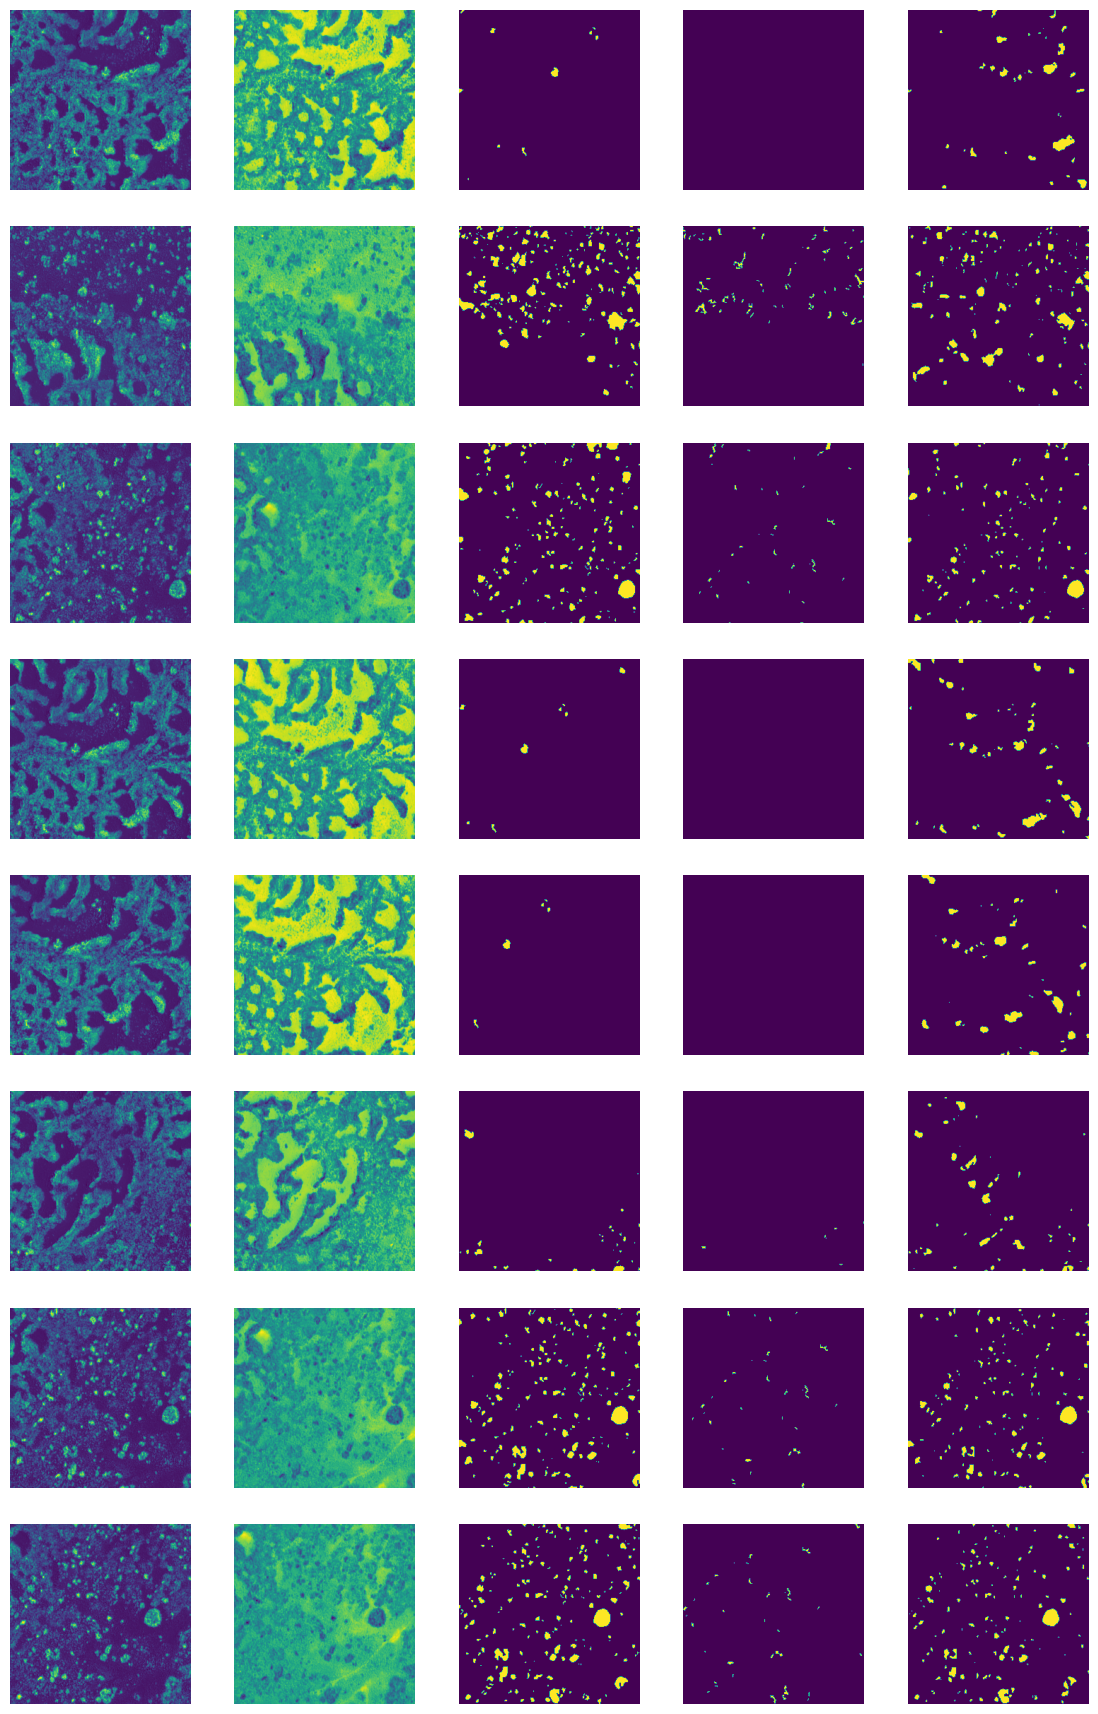

In [12]:
# Print one batch on the training/test data!
for i in range(1):
    test_images, real_label = next(test_generator)
    #5 images per row: pan, ndvi, label, weight, prediction
    prediction = model.predict(test_images, steps=1)
    prediction[prediction>0.5]=1
    prediction[prediction<=0.5]=0
    display_images(np.concatenate((test_images, real_label, prediction), axis = -1))